MovingPandas是一个基于Python和GeoPandas的开源地理时空数据处理库，用于处理移动物体的轨迹数据。它提供了一组强大的工具，可以轻松地加载、分析和可视化移动物体的轨迹。通过使用MovingPandas，用户可以轻松地处理和分析移动对象数据，并从中提取有关行为、模式和趋势的见解。无论是处理交通流量数据、物流轨迹数据还是动物迁徙数据，MovingPandas都是一个强大的地理可视化工具。

MovingPandas库具有以下主要特性：

+ 轨迹对象：MovingPandas引入了Trajectory对象，用于表示和管理轨迹数据。该对象包含了时间、位置和属性信息，方便对轨迹进行操作和分析。
+ 时空切片：MovingPandas支持时空切片操作，可以按照时间和空间条件对轨迹数据进行筛选和分割。
+ 轨迹分析：MovingPandas提供了丰富的轨迹分析功能，包括计算轨迹长度、速度、方向、加速度等指标，以及轨迹聚类、交互和相似性分析。
+ 轨迹可视化：MovingPandas可以方便地将轨迹数据可视化，支持在地图上绘制轨迹线、点、热力图等，帮助用户更直观地理解移动物体的行为。
+ 数据格式兼容：MovingPandas支持多种常见的地理数据格式，包括GeoJSON、Shapefile等，方便用户加载和保存轨迹数据。

MovingPandas官方仓库地址为：[movingpandas](https://github.com/movingpandas/movingpandas)。MovingPandas官方示例代码仓库地址为：[movingpandas-examples](https://github.com/movingpandas/movingpandas-examples)。本文所有实验数据来自于：[movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)。

MovingPandas作者推荐在Python 3.8及以上环境下安装MovingPandas，并建议使用conda进行安装。可以使用以下命令来安装MovingPandas：


```python
conda install -c conda-forge movingpandas
```

由于MovingPandas的依赖环境较为复杂，所以不推荐使用pip进行安装。如果坚持使用pip进行安装，可以按照以下命令来安装MovingPandas：

```python
pip install movingpandas
# 本文必安装第三方库
pip install contextily
# 以下第三方库可选
pip install hvplot
pip install cartopy
pip install geoviews
```



下面的代码展示了MovingPandas的版本信息，本文所用Python版本为Python3.10。

In [1]:
# jupyter notebook环境去除warning
import warnings
warnings.filterwarnings("ignore")

# 查看movingpandas版本及依赖库版本信息
import movingpandas as mpd
mpd.show_versions()


MovingPandas 0.16.1

SYSTEM INFO
-----------
python     : 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
executable : /opt/conda/envs/python35-paddle120-env/bin/python
machine    : Linux-5.4.0-104-generic-x86_64-with-glibc2.31

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 2.0.2
fiona      : 1.9.4.post1
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : None
hvplot     : None
geoviews   : None
stonesoup  : None


# 1 使用入门

## 1.1 基础结构

In [2]:
# 加载第三方库
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
# hvPlot是建立在数据可视化库holoviews的一个高级封装库
# import hvplot.pandas 

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
# hvplot通常与HoloViews集成使用
# from holoviews import opts

# 设置绘图界面
# opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

### 1.1.1 Trajectory类
MovingPandas提供Trajectory对象用于表示单个轨迹的对象。它由一系列坐标点组成。Trajectory对象初始化参数如下：

```python
class Trajectory:
    def __init__(
        self,
        df,
        traj_id,
        obj_id=None,
        t=None,
        x=None,
        y=None,
        crs="epsg:4326",
        parent=None,
    ):
```

其中各个参数解释如下：

+ df：具有GeoPandas的geometry坐标列和时间戳索引的GeoDataFrame，或Pandas的DataFrame。必填参数。
+ traj_id：任意类型，表示轨迹的唯一标识符。必填参数。
+ obj_id：任意类型，表示移动物体的唯一标识符。默认为 None。
+ t：表示包含时间戳的列名，默认为 None。
+ x：表示包含x坐标的列名，使用Pandas的DataFrame需指定。默认为 None。
+ y：表示包含y坐标的列名，使用Pandas的DataFrame需指定。默认为 None。
+ crs：表示 x/y 坐标的坐标参考系统。默认为 "epsg:4326"，即 WGS84。
+ parent：一个Trajectory 对象，表示父轨迹。默认为 None。


由Trajectory轨迹对象的初始化参数可知，MovingPandas用相关点位置信息和其时间信息来表示轨迹。下面用一个实例代码来展示Trajectory对象的使用。

首先创建一个用于表示位置和其对应时间信息的GeoDataFrame对象。

In [3]:
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import movingpandas as mpd
from datetime import datetime

# 创建DataFrame对象
df = pd.DataFrame([
    {'geometry': Point(0, 0), 't': datetime(2023, 7, 1, 12, 0, 0)},
    {'geometry': Point(6, 0), 't': datetime(2023, 7, 1, 12, 6, 0)},
    {'geometry': Point(6, 6), 't': datetime(2023, 7, 1, 12, 10, 0)},
    {'geometry': Point(9, 9), 't': datetime(2023, 7, 1, 12, 15, 0)}])
# 设置索引轴
df = df.set_index('t')

# 创建GeoDataFrame对象
# EPSG:3857是在线地图常用的投影坐标系，以米为单位
gdf = GeoDataFrame(df, crs='EPSG:3857')
gdf

,geometry
t,
2023-07-01 12:00:00,POINT (0.000 0.000)
2023-07-01 12:06:00,POINT (6.000 0.000)
2023-07-01 12:10:00,POINT (6.000 6.000)
2023-07-01 12:15:00,POINT (9.000 9.000)


然后基于GeoDataFrame对象创建轨迹对象。

In [4]:
# 创建Trajectory对象
# 1表示轨迹标识符
toy_traj = mpd.Trajectory(gdf, 1)
toy_traj

Trajectory 1 (2023-07-01 12:00:00 to 2023-07-01 12:15:00) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)

接下来可以可视化轨迹路径，横纵轴表示点的xy坐标。

<Axes: >

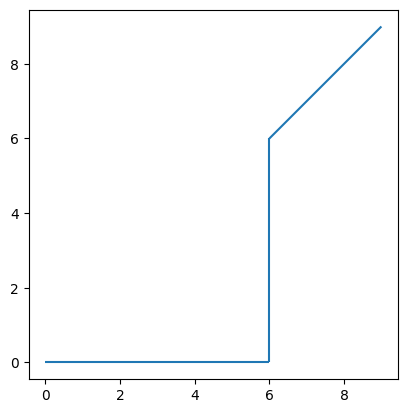

In [5]:
# 可视化路径
toy_traj.plot()

In [6]:
# 交互式展示
# toy_traj.hvplot()

此外也可以直接调用toy_traj的GeoPandas对象进行可视化展示。

<Axes: >

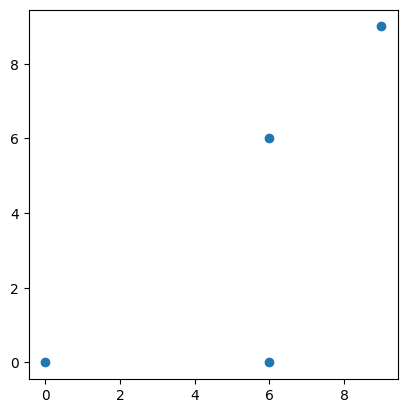

In [7]:
toy_traj.df.plot()

### 1.1.2 TrajectoryCollection类

TrajectoryCollection类是一个集合，用于存储多个Trajectory 对象。它提供了对整个轨迹集合进行操作和分析的功能。可以使用 TrajectoryCollection来合并多个轨迹为一个对象、筛选轨迹、进行空间查询、可视化等。TrajectoryCollection对象初始化参数如下：

```python
class TrajectoryCollection:
    def __init__(
        self,
        data,
        traj_id_col=None,
        obj_id_col=None,
        t=None,
        x=None,
        y=None,
        crs="epsg:4326",
        min_length=0,
        min_duration=None,
    )
```
 
 其中大部分参数与Trajectory对象的参数一致，不同参数解释如下：
 + min_length: 轨迹的最小长度，低于该长度的轨迹将被丢弃。
 + min_duration: 轨迹的期望最小持续时间，低于该续时间的轨迹将被丢弃。
 

**直接创建TrajectoryCollection对象**

In [8]:
# 创建两条轨迹
df = pd.DataFrame(
    {
        "t": pd.date_range("2023-07-01", periods=5, freq="min"),
        "trajectory_id": [1, 1, 2, 2, 2],
        "geometry": [Point(0, 0), Point(0, 1), Point(1, 2), Point(1, 3), Point(2, 4)],
    }
)
gdf = gpd.GeoDataFrame(df, crs='EPSG:3857')
gdf

,t,trajectory_id,geometry
0,2023-07-01 00:00:00,1,POINT (0.000 0.000)
1,2023-07-01 00:01:00,1,POINT (0.000 1.000)
2,2023-07-01 00:02:00,2,POINT (1.000 2.000)
3,2023-07-01 00:03:00,2,POINT (1.000 3.000)
4,2023-07-01 00:04:00,2,POINT (2.000 4.000)


In [9]:
# 创建TrajectoryCollection对象，用trajectory_id作为单个轨迹的唯一标识
tc = mpd.TrajectoryCollection(gdf, traj_id_col='trajectory_id', t='t')
tc

TrajectoryCollection with 2 trajectories

<Axes: >

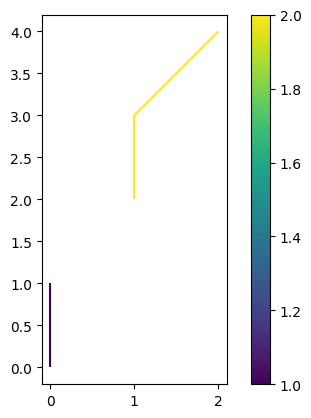

In [10]:
# 绘制轨迹, column指定轨迹对象，legend展示轨迹持续时间
import matplotlib.cm as cm
tc.plot(column='trajectory_id', legend=True)


In [11]:
# 交互式展示轨迹
# tc.hvplot()

此外我们还可以从TrajectoryCollection提取单个轨迹，或者筛选所需要的轨迹。

In [12]:
# 从TrajectoryCollection提取单个轨迹
my_traj = tc.trajectories[1]
print(my_traj)

Trajectory 2 (2023-07-01 00:02:00 to 2023-07-01 00:04:00) | Size: 3 | Length: 2.4m
Bounds: (1.0, 2.0, 2.0, 4.0)
LINESTRING (1 2, 1 3, 2 4)


In [13]:
#　筛选路径持续时间大于一分钟的
min_duration = timedelta(minutes=1)
tc.trajectories = [traj for traj in tc if traj.get_duration() > min_duration]
print(tc.trajectories)

[Trajectory 2 (2023-07-01 00:02:00 to 2023-07-01 00:04:00) | Size: 3 | Length: 2.4m
Bounds: (1.0, 2.0, 2.0, 4.0)
LINESTRING (1 2, 1 3, 2 4)]


**从文件数据创建TrajectoryCollection对象**

TrajectoryCollection可以通过GeoPandas函数从各种地理空间数据存储中读取数据来创建，也可以利用Pandas从各类文件类型中读取数据进行创建。


下面展示了直接通过csv文件创建TrajectoryCollection对象，数据下载地址为：[movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)

In [14]:
# 读取数据
df = pd.read_csv('data/geolife_small.csv', delimiter=';')
df.head()

,X,Y,fid,id,sequence,trajectory_id,tracker,t
0,116.391305,39.898573,1,1,1,1,19,2008-12-11 04:42:14+00
1,116.391317,39.898617,2,2,2,1,19,2008-12-11 04:42:16+00
2,116.390928,39.898613,3,3,3,1,19,2008-12-11 04:43:26+00
3,116.390833,39.898635,4,4,4,1,19,2008-12-11 04:43:32+00
4,116.389410,39.898723,5,5,5,1,19,2008-12-11 04:43:47+00


In [15]:
# 转换为traj_collection对象
traj_collection = mpd.TrajectoryCollection(df, 'trajectory_id', t='t', x='X', y='Y')
print(traj_collection)

TrajectoryCollection with 5 trajectories


<Axes: >

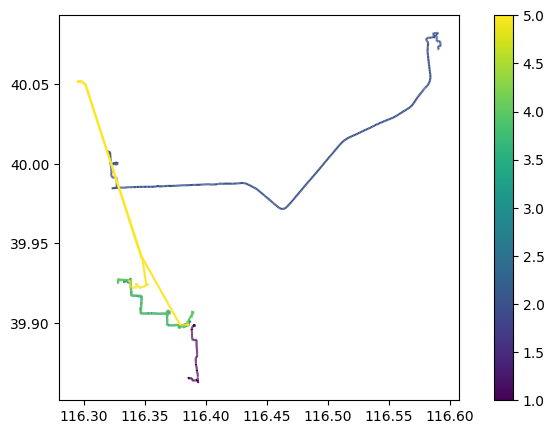

In [16]:
# 绘制轨迹
traj_collection.plot(column='trajectory_id', legend=True, figsize=(9,5))

## 1.2 基础函数

MovingPandas中的函数可以同时适用于单个轨迹（Trajectory）对象和轨迹集合（TrajectoryCollection）对象，以实现对单条和多条轨迹的分析。

### 1.2.1 移动信息添加函数

MovingPandas提供add_speed、add_distance、add_direction、add_timedelta、add_timedelta和add_acceleration等移动信息添加函数来处理移动数据。这些函数的接口如下：

```python
add_speed(overwrite=False, name=SPEED_COL_NAME, units=UNITS())
add_distance(overwrite=False, name=DISTANCE_COL_NAME, units=None)
add_direction(overwrite=False, name=DIRECTION_COL_NAME)
add_angular_difference(overwrite=False,name=ANGULAR_DIFFERENCE_COL_NAM):
add_timedelta(overwrite=False, name=TIMEDELTA_COL_NAME)
add_acceleration(overwrite=False, name=ACCELERATION_COL_NAME, units=UNITS())
```

所有函数均使用系统默认值或全局变量，具体函数介绍如下：

+ add_speed: 用于计算移动对象的速度。根据两个时间点之间的距离和时间差来计算速度。参数overwrite表示是否覆盖现有的速度列，name表示速度列的名称，units表示速度的单位，名字和单位不指定则使用默认值。
+ add_distance: 用于计算移动对象的距离。根据两个时间点之间的直线距离异来计算距离。参数overwrite表示是否覆盖现有的距离列，name表示距离列的名称，units表示距离的单位。
+ add_direction: 用于计算移动对象的方向。根据两个时间点之间的坐标差异来计算方向。参数overwrite表示是否覆盖现有的方向列，name表示方向列的名称。方向值以度为单位，从北开始顺时针旋转，范围值为[0,360)。
+ add_angular_difference: 用于计算两个对象之间的角度差。根据移动对象的方向信息来计算两个对象之间的角度差。参数overwrite表示是否覆盖现有的方向列，name表示方向列的名称。角度范围值为[0,180]。
+ add_timedelta: 用于计算移动对象的时间差。根据时间戳之间的差异来计算时间差。参数overwrite表示是否覆盖现有的时间差列，name表示时间差列的名称。时间差为当前行与前一行之差。
+ add_acceleration: 用于计算移动对象的加速度。根据速度和时间差来计算加速度。参数overwrite表示是否覆盖现有的加速度列，name表示加速度列的名称，units表示加速度的单位。


以下代码详细介绍了这些函数的使用。

In [17]:
# 创建轨迹
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2023,7,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2023,7,1,12,0,6)},
  {'geometry':Point(6,6), 't':datetime(2023,7,1,12,0,11)},
  {'geometry':Point(9,9), 't':datetime(2023,7,1,12,0,14)}
]).set_index('t')
gdf = GeoDataFrame(df, crs='EPSG:3857')
toy_traj = mpd.Trajectory(gdf, 1)
toy_traj

Trajectory 1 (2023-07-01 12:00:00 to 2023-07-01 12:00:14) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)

In [18]:
# 查看轨迹的坐标系，以米为单位
toy_traj.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# 添加速度列，不指定单位则以米为单位
toy_traj.add_speed(overwrite=True)
toy_traj.df

,geometry,speed
t,,
2023-07-01 12:00:00,POINT (0.000 0.000),1.000000
2023-07-01 12:00:06,POINT (6.000 0.000),1.000000
2023-07-01 12:00:11,POINT (6.000 6.000),1.200000
2023-07-01 12:00:14,POINT (9.000 9.000),1.414214


In [20]:
# 添加自定义定单位的速度列
toy_traj.add_speed(overwrite=True, name="speed (ft/min)", units=("ft", "min"))
toy_traj.df

,geometry,speed,speed (ft/min)
t,,,
2023-07-01 12:00:00,POINT (0.000 0.000),1.000000,196.850394
2023-07-01 12:00:06,POINT (6.000 0.000),1.000000,196.850394
2023-07-01 12:00:11,POINT (6.000 6.000),1.200000,236.220472
2023-07-01 12:00:14,POINT (9.000 9.000),1.414214,278.388497


In [21]:
# 其他列的添加
toy_traj.add_distance(overwrite=True, name="distance (m)", units="m")
toy_traj.add_direction(overwrite=True)
toy_traj.add_timedelta(overwrite=True)
toy_traj.add_angular_difference(overwrite=True)
toy_traj.add_acceleration(overwrite=True, name="acceleration (mph/s)", units=("mi", "h", "s"))
toy_traj.df

,geometry,speed,speed (ft/min),distance (m),direction,timedelta,angular_difference,acceleration (mph/s)
t,,,,,,,,
2023-07-01 12:00:00,POINT (0.000 0.000),1.000000,196.850394,0.000000,90.0,NaT,0.0,0.000000
2023-07-01 12:00:06,POINT (6.000 0.000),1.000000,196.850394,6.000000,90.0,0 days 00:00:06,0.0,0.000000
2023-07-01 12:00:11,POINT (6.000 6.000),1.200000,236.220472,6.000000,0.0,0 days 00:00:05,90.0,0.089477
2023-07-01 12:00:14,POINT (9.000 9.000),1.414214,278.388497,4.242641,45.0,0 days 00:00:03,45.0,0.159727


<Axes: >

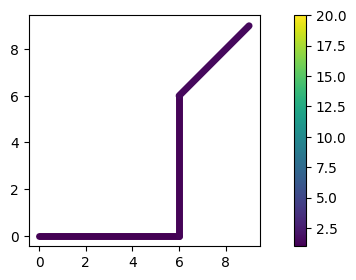

In [22]:
# 可视化某列结果绘制结果
toy_traj.plot(column='speed', linewidth=5, capstyle='round', figsize=(9,3), legend=True, vmax=20)

### 1.2.2 轨迹位置提取函数

MovingPandas提供add_speed、add_distance、add_direction、add_timedelta、add_timedelta和add_acceleration等轨迹位置提取函数用于提取轨迹位置相关信息数据。具体函数介绍如下：

+ `get_start_location()`: 该函数用于获取移动对象的起始位置。它返回移动对象的起始位置坐标。
+ `get_end_location()`: 该函数用于获取移动对象的结束位置。它返回移动对象的结束位置坐标。
+ `get_position_at(t, method="interpolated")`: 该函数用于在给定的时间点（t）处获取移动对象的位置。参数t表示所需位置的时间点，而可选的参数method指定了用于获取位置的方法，默认为"interpolated"，表示使用插值方法获取位置。
+ `get_segment_between(t1, t2)`: 这个函数用于获取两个给定时间点（t1和t2）之间的移动对象的片段。它返回包含这段时间内移动对象的子集。
+ `clip(polygon, point_based=False)`: 该函数用于剪裁移动对象，使其仅保留在指定多边形区域内的部分。参数polygon表示用于剪裁的多边形区域，而可选的参数point_based指定剪裁是否基于点而不是线段。默认情况下，剪裁是基于线段的。此外，MovingPandas也提供了intersection函数来算轨迹数据与空间几何图形之间的交集，效果类似clip函数，具体使用可以参考官方文档。

以下代码详细介绍了这些函数的使用。

In [23]:
# 创建轨迹
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2023,7,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2023,7,1,12,6,6)},
  {'geometry':Point(6,6), 't':datetime(2023,7,1,12,10,11)},
  {'geometry':Point(9,9), 't':datetime(2023,7,1,12,19,14)}
]).set_index('t')
gdf = GeoDataFrame(df, crs='EPSG:3857')
toy_traj = mpd.Trajectory(gdf, 1)
toy_traj

Trajectory 1 (2023-07-01 12:00:00 to 2023-07-01 12:19:14) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)

**起始位置和结束位置**

<Axes: >

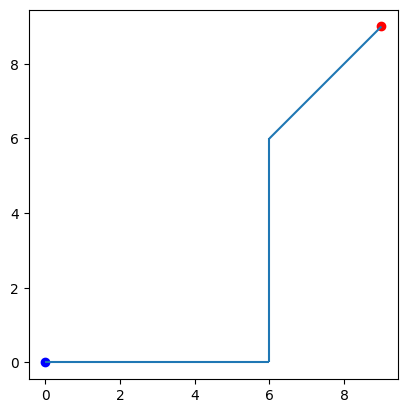

In [24]:
ax = toy_traj.plot()
# 提取轨迹起始点和结束点
gpd.GeoSeries(toy_traj.get_start_location()).plot(ax=ax, color='blue')
gpd.GeoSeries(toy_traj.get_end_location()).plot(ax=ax, color='red')

**中间位置**

In [25]:
# 提取轨迹中的一个时间点的位置
t = datetime(2023,7,1,12,6,0)
# 改时间点不同位置信息获取方式
print(toy_traj.get_position_at(t, method="nearest"))
print(toy_traj.get_position_at(t, method="interpolated"))
print(toy_traj.get_position_at(t, method="ffill"))
print(toy_traj.get_position_at(t, method="bfill"))


POINT (6 0)
POINT (5.9016393442622945 0)
POINT (0 0)
POINT (6 0)


<Axes: >

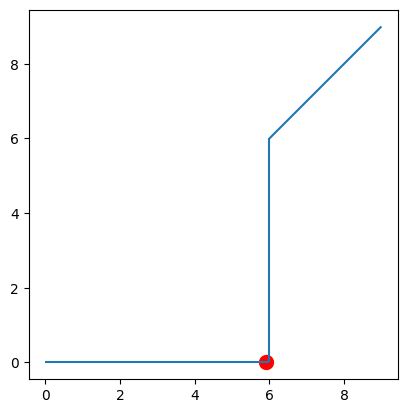

In [26]:
point = toy_traj.get_position_at(t, method="interpolated")
ax = toy_traj.plot()
gpd.GeoSeries(point).plot(ax=ax, color='red', markersize=100)

**轨迹片段**

In [27]:
# 提取轨迹中的一个片段
segment = toy_traj.get_segment_between(datetime(2023,7,1,12,6,0), datetime(2023,7,1,12,12,0))
print(segment)

Trajectory 1_2023-07-01 12:06:00 (2023-07-01 12:06:06 to 2023-07-01 12:10:11) | Size: 2 | Length: 6.0m
Bounds: (6.0, 0.0, 6.0, 6.0)
LINESTRING (6 0, 6 6)


<Axes: >

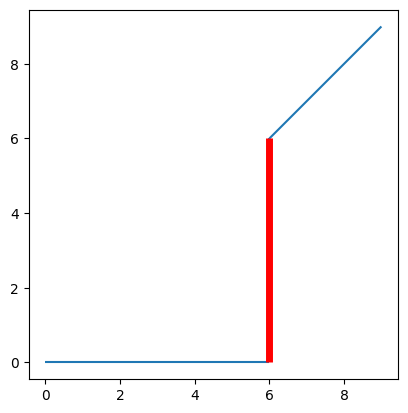

In [28]:
ax = toy_traj.plot()
segment.plot(ax=ax, color='red', linewidth=5)

**轨迹区域**

In [29]:
xmin, xmax, ymin, ymax = 2, 8, -10, 5
# 设置区域
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

In [30]:
# 提取位于该区域的轨迹
intersections = toy_traj.clip(polygon)
intersections

TrajectoryCollection with 1 trajectories

<Axes: >

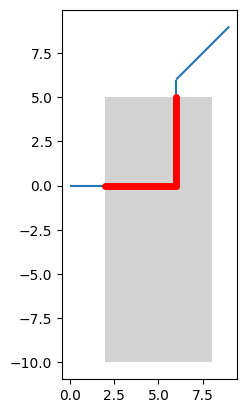

In [31]:
# 绘制轨迹区域
ax = toy_traj.plot()
gpd.GeoSeries(polygon).plot(ax=ax, color='lightgray')
intersections.plot(ax=ax, color='red', linewidth=5, capstyle='round')

<Axes: >

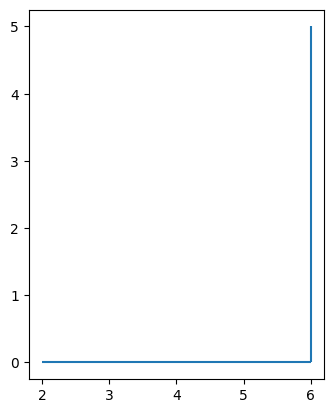

In [32]:
# 单独绘制轨迹区域
intersections = toy_traj.clip(polygon)
intersections.plot()

### 1.2.3 与GeoPandas交互

MovingPandas提供to_point_gdf，to_line_gdf和to_traj_gdf函数以按照不同规则将轨迹类Trajectories和TrajectoryCollections转换回为GeoPandas的GeoDataFrames结构。这些函数解释如下：

+ `to_point_gdf(return_orig_tz=False)`，将轨迹对象转换为与每个点相关的GeoDataFrame。return_orig_tz用于指定是否返回与原始时区匹配的时间戳。默认为False，时间戳会根据本地时区进行转换。
+ `to_line_gdf()`，将轨迹对象转换为每条线相关的GeoDataFrame。
+ `to_traj_gdf(wkt=False, agg=False)`，返回一个GeoDataFrame，其每一行表示一条轨迹。wkt用于指定是否将轨迹几何表示为Well-Known Text (WKT)格式。默认为False，返回几何对象。agg用于指定是否对轨迹进行聚合。默认为False，不进行聚合，agg可选参数见代码。

In [33]:
# 读取数据
df = pd.read_csv('data/geolife_small.csv', delimiter=';')
df.head()
# 转换为traj_collection对象
traj_collection = mpd.TrajectoryCollection(df, 'trajectory_id', t='t', x='X', y='Y')
print(traj_collection)

TrajectoryCollection with 5 trajectories


In [34]:
# 转换为点GeoDataFrame
traj_collection.to_point_gdf().head()

,fid,id,sequence,trajectory_id,tracker,geometry
t,,,,,,
2008-12-11 04:42:14,1,1,1,1,19,POINT (116.39131 39.89857)
2008-12-11 04:42:16,2,2,2,1,19,POINT (116.39132 39.89862)
2008-12-11 04:43:26,3,3,3,1,19,POINT (116.39093 39.89861)
2008-12-11 04:43:32,4,4,4,1,19,POINT (116.39083 39.89863)
2008-12-11 04:43:47,5,5,5,1,19,POINT (116.38941 39.89872)


In [35]:
# 转换为线GeoDataFrame
traj_collection.to_line_gdf().head()

,fid,id,sequence,trajectory_id,tracker,t,prev_t,geometry
0,2,2,2,1,19,2008-12-11 04:42:16,2008-12-11 04:42:14,"LINESTRING (116.39131 39.89857, 116.39132 39.8..."
1,3,3,3,1,19,2008-12-11 04:43:26,2008-12-11 04:42:16,"LINESTRING (116.39132 39.89862, 116.39093 39.8..."
2,4,4,4,1,19,2008-12-11 04:43:32,2008-12-11 04:43:26,"LINESTRING (116.39093 39.89861, 116.39083 39.8..."
3,5,5,5,1,19,2008-12-11 04:43:47,2008-12-11 04:43:32,"LINESTRING (116.39083 39.89863, 116.38941 39.8..."
4,6,6,6,1,19,2008-12-11 04:43:50,2008-12-11 04:43:47,"LINESTRING (116.38941 39.89872, 116.39052 39.8..."


In [36]:
# 每条轨迹单独聚合GeoDataFrame
traj_collection.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,1,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (116.39131 39.89857, 116.39132 39.8...",6207.020261,186.681376
1,2,2009-06-29 07:02:25,2009-06-29 11:13:12,"LINESTRING (116.59096 40.07196, 116.59091 40.0...",38764.575483,250.585295
2,3,2009-02-04 04:32:53,2009-02-04 11:20:12,"LINESTRING (116.38569 39.89977, 116.38565 39.8...",12745.157506,304.115160
3,4,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (116.38805 39.90342, 116.38804 39.9...",14363.780551,300.732843
4,5,2009-02-25 09:47:03,2009-02-25 14:31:24,"LINESTRING (116.38526 39.90027, 116.38525 39.9...",39259.779560,305.200501


## 1.3 轨迹处理

### 1.3.1 轨迹提取

MovingPandas提供了TemporalSplitter、ObservationGapSplitter，StopSplitter，SpeedSplitter类来根据不同规则从轨迹中提取指定轨迹片段。具体如下：

+ TemporalSplitter：使用规则的时间间隔将轨迹拆分为子区间。
+ ObservationGapSplitter：根据观测时间之间的间隔将轨迹拆分为子区间。如果两个连续观测之间的间隔超过指定的阈值，则认为是该轨迹需要拆分。
+ StopSplitter：根据停留点的定义将轨迹拆分为子区间。停留点是指轨迹在相对较小的区域内停留了一段时间。
+ SpeedSplitter：据速度阈值将轨迹拆分为子区间。如果轨迹在某段速度低于指定阈值，则需要在此拆分轨迹。

这些类都只需待处理轨迹进行初始化，然后调用split函数进行轨迹提取。具体使用见下列代码。

In [37]:
import matplotlib.pyplot as plt

# 读取数据
gdf = read_file('data/geolife_small.gpkg').to_crs('EPSG:3857')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
# 共五条轨迹
tc.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,1,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (12956620.805 4851214.113, 12956622...",8101.428690,186.679744
1,2,2009-06-29 07:02:25,2009-06-29 11:13:12,"LINESTRING (12978845.964 4876404.973, 12978840...",50621.731208,250.500509
2,3,2009-02-04 04:32:53,2009-02-04 11:20:12,"LINESTRING (12955995.635 4851388.236, 12955991...",16626.383723,304.099365
3,4,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (12956258.794 4851917.156, 12956257...",18739.337154,300.716597
4,5,2009-02-25 09:47:03,2009-02-25 14:31:24,"LINESTRING (12955947.434 4851460.354, 12955946...",51327.869585,305.185128


**TemporalSplitter**

In [38]:
# 将轨迹切分为以每小时为单位的轨迹片段，min_length表示删除轨迹长度小于该值的轨迹片段,min_lwngth取决于轨迹的单位
split = mpd.TemporalSplitter(tc).split(mode="hour", min_length=20000)
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,2_2009-06-29 07:00:00,2009-06-29 07:02:25,2009-06-29 07:59:55,"LINESTRING (12978845.964 4876404.973, 12978840...",40106.105641,245.123482
1,5_2009-02-25 10:00:00,2009-02-25 10:00:04,2009-02-25 10:54:47,"LINESTRING (12955251.019 4851210.485, 12955248...",25455.673254,337.129155


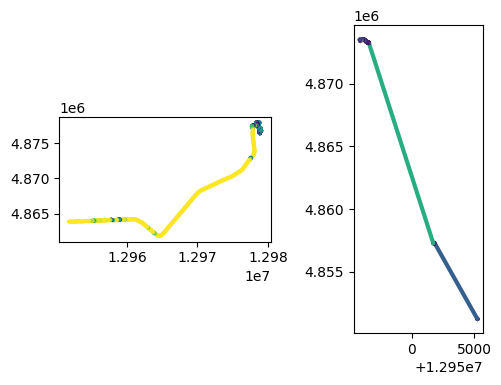

In [39]:
# 绘制轨迹
fig, axes = plt.subplots(nrows=1, ncols=len(split), figsize=(6,4))
for i, traj in enumerate(split):
    traj.plot(ax=axes[i], linewidth=3.0, capstyle='round', column='speed', vmax=20)

**ObservationGapSplitter**

In [40]:
# 如果两个连续观测超过间隔gap，如30分钟，则认为该轨迹需要拆分
split = mpd.ObservationGapSplitter(tc).split(gap=timedelta(minutes=30),min_length=0)
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,1_0,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (12956620.805 4851214.113, 12956622...",8101.428690,186.679744
1,2_0,2009-06-29 07:02:25,2009-06-29 08:20:15,"LINESTRING (12978845.964 4876404.973, 12978840...",47469.321958,252.952783
2,2_1,2009-06-29 10:57:17,2009-06-29 11:13:12,"LINESTRING (12948649.439 4867034.108, 12948650...",3040.348707,139.615947
3,3_0,2009-02-04 04:32:53,2009-02-04 04:35:03,"LINESTRING (12955995.635 4851388.236, 12955991...",311.729231,42.937430
4,3_1,2009-02-04 10:03:21,2009-02-04 11:20:12,"LINESTRING (12956011.999 4851497.646, 12956043...",16228.264596,303.229612
5,4_0,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (12956258.794 4851917.156, 12956257...",18739.337154,300.716597
6,5_0,2009-02-25 09:47:03,2009-02-25 10:54:47,"LINESTRING (12955947.434 4851460.354, 12955946...",27149.500896,335.377580
7,5_1,2009-02-25 13:30:22,2009-02-25 14:31:24,"LINESTRING (12945965.972 4873487.115, 12945952...",24074.321167,165.727187


**StopSplitter**

In [41]:
# 如果轨迹在某一点为圆心，直径为10范围内停留60s，则认为轨迹需要在该段分割
split = mpd.StopSplitter(tc).split(max_diameter=10, min_duration=timedelta(seconds=60))
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,1_2008-12-11 04:42:14,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (12956620.805 4851214.113, 12956622...",8101.428690,186.679744
1,2_2009-06-29 07:02:25,2009-06-29 07:02:25,2009-06-29 07:05:30,"LINESTRING (12978845.964 4876404.973, 12978840...",608.233016,29.527683
2,2_2009-06-29 07:06:55,2009-06-29 07:06:55,2009-06-29 08:02:40,"LINESTRING (12979026.970 4876730.251, 12979022...",41655.491556,246.215181
3,2_2009-06-29 08:03:40,2009-06-29 08:03:40,2009-06-29 11:13:12,"LINESTRING (12949605.674 4863764.794, 12949579...",8333.942283,357.660458
4,3_2009-02-04 04:32:53,2009-02-04 04:32:53,2009-02-04 11:20:12,"LINESTRING (12955995.635 4851388.236, 12955991...",16626.383723,304.099365
5,4_2009-03-10 10:36:45,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (12956258.794 4851917.156, 12956257...",18739.337154,300.716597
6,5_2009-02-25 09:47:03,2009-02-25 09:47:03,2009-02-25 14:31:24,"LINESTRING (12955947.434 4851460.354, 12955946...",51327.869585,305.185128


**SpeedSplitter**

In [42]:
# 把超过30分钟速度低于1地理系统单位/秒的轨迹分开
split = mpd.SpeedSplitter(tc).split(speed=1, duration=timedelta(minutes=30))
split.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,1_0,2008-12-11 04:42:14,2008-12-11 05:15:46,"LINESTRING (12956620.805 4851214.113, 12956622...",8048.160604,186.679744
1,2_0,2009-06-29 07:02:25,2009-06-29 08:20:15,"LINESTRING (12978845.964 4876404.973, 12978840...",47336.977010,252.952783
2,2_1,2009-06-29 10:57:22,2009-06-29 11:10:07,"LINESTRING (12948650.441 4867044.718, 12948642...",2915.988294,138.780873
3,3_0,2009-02-04 04:32:53,2009-02-04 04:35:03,"LINESTRING (12955995.635 4851388.236, 12955991...",310.440780,42.937430
4,3_1,2009-02-04 10:03:23,2009-02-04 11:20:12,"LINESTRING (12956043.836 4851524.490, 12956025...",15962.930350,302.882421
5,4_0,2009-03-10 10:36:45,2009-03-10 12:01:07,"LINESTRING (12956258.794 4851917.156, 12956257...",18349.431950,300.716597
6,5_0,2009-02-25 09:47:03,2009-02-25 10:54:47,"LINESTRING (12955947.434 4851460.354, 12955946...",27081.554127,335.377580
7,5_1,2009-02-25 13:30:23,2009-02-25 14:31:24,"LINESTRING (12945952.057 4873516.928, 12945956...",24006.683028,165.708568


### 1.3.2 轨迹压缩与平滑

MovingPandas提供了各种轨迹压缩类和轨迹平滑类，以减少轨迹对象的大小（点的数量），从而加快处理速度。

压缩轨迹类都只需待处理轨迹进行初始化，然后调用generalize函数进行轨迹压缩。用于压缩轨迹的类有：

+ MinDistanceGeneralizer（最小距离）：通过删除原始数据中的一些点来压缩轨迹，被删除的点与相邻点之间的距离必须小于指定的最小距离。
+ DouglasPeuckerGeneralizer（道格拉斯-普克）：道格拉斯-普克算法根据指定的阈值，逐渐删除原始数据中的部分点，从而生成一个近似的简化线串或轨迹。
+ MaxDistanceGeneralizer（最大距离）：删除原始数据中与相邻点之间距离超过指定最大距离的点，从而实现轨迹压缩。
+ MinTimeDeltaGeneralizer（最小时间间隔）：通过删除两个连续时间戳之间时间间隔小于指定最小时间间隔的数据点来实现轨迹压缩。
+ TopDownTimeRatioGeneralizer（自顶向下时间比率）：根据预先设定的时间比率，逐渐删除原始数据中的数据点。


平滑轨迹类目前只提供了KalmanSmootherCV类进行轨迹平滑，KalmanSmootherCV需要额外安装第三库且处理流程麻烦，所以一般都是效果相近的压缩轨迹类。



In [43]:
# 读取数据
gdf = read_file('data/geolife_small.gpkg').to_crs('EPSG:3857')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
# 提取单条轨迹进行操作
original_traj = tc.trajectories[1]
# 可以看到轨迹包括897个点
print(original_traj)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 50621.7m
Bounds: (12948595.449314836, 4861831.088215791, 12979030.643375682, 4877940.244020148)
LINESTRING (12978845.964340456 4876404.972802613, 12978840.175726935 4876411.664456934, 12978837.281


In [44]:
# tolerance设置连续点之间的最小距离
mpd.MinDistanceGeneralizer(original_traj).generalize(tolerance=1.0)


Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 818 | Length: 50611.6m
Bounds: (12948595.449314836, 4861831.088215791, 12979030.643375682, 4877940.244020148)
LINESTRING (12978845.964340456 4876404.972802613, 12978840.175726935 4876411.664456934, 12978837.281

In [45]:
# tolerance表示距离公差，具体使用见算法介绍
mpd.DouglasPeuckerGeneralizer(original_traj).generalize(tolerance=1.0)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 564 | Length: 50606.8m
Bounds: (12948595.449314836, 4861831.088215791, 12979030.643375682, 4877940.244020148)
LINESTRING (12978845.964340456 4876404.972802613, 12978837.281420175 4876414.573873267, 12978852.086

In [46]:
# tolerance设置连续点之间的最大距离
mpd.MaxDistanceGeneralizer(original_traj).generalize(tolerance=1.0)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 324 | Length: 50166.8m
Bounds: (12948595.449314836, 4861831.088215791, 12979029.752819754, 4877940.244020148)
LINESTRING (12978845.964340456 4876404.972802613, 12978837.281420175 4876414.573873267, 12978852.086

In [47]:
# tolerance连续轨迹最小的时间距离
mpd.MinTimeDeltaGeneralizer(original_traj).generalize(tolerance=timedelta(minutes=1))

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 76 | Length: 47565.6m
Bounds: (12948636.414887449, 4862053.18880025, 12979029.30754179, 4877912.7458354365)
LINESTRING (12978845.964340456 4876404.972802613, 12978815.79675845 4876446.868451926, 12978780.3971

In [48]:
# tolerance距离公差，该类处理速度很慢
mpd.TopDownTimeRatioGeneralizer(original_traj).generalize(tolerance=1.0)

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 756 | Length: 50616.4m
Bounds: (12948595.449314836, 4861831.088215791, 12979030.643375682, 4877940.244020148)
LINESTRING (12978845.964340456 4876404.972802613, 12978840.175726935 4876411.664456934, 12978837.281

### 1.3.3 轨迹停留检测


MovingPandas提供了轨迹停留检测的功能，事实上轨迹停留并不意味着轨迹运动速度为零，事实上由于跟踪不准确，物体移动速度很少达到0，例如GPS轨迹往往会在物体的停止位置周围不断移动。所以MovingPandas检测轨迹停留的方式为如果物体停留在指定大小的区域内超过一段时间，则判定为轨迹停留。具体使用如下：

In [49]:
# 读取数据
gdf = read_file('data/geolife_small.gpkg').to_crs('EPSG:3857')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
# 使用单个轨迹进行运算，也可以轨迹集合
my_traj = tc.trajectories[0]
my_traj

Trajectory 1 (2008-12-11 04:42:14 to 2008-12-11 05:15:46) | Size: 466 | Length: 8101.4m
Bounds: (12955985.950308602, 4845963.532957837, 12956871.051579898, 4851235.877839145)
LINESTRING (12956620.805364596 4851214.112520242, 12956622.141198486 4851220.49700885, 12956578.8379

In [50]:
# 创建停留检测器
detector = mpd.TrajectoryStopDetector(tc)
# 获取在某个直径为10的区域停留60s以上的轨迹时间范围
stop_time_ranges = detector.get_stop_time_ranges(min_duration=timedelta(seconds=60), max_diameter=10)
for x in stop_time_ranges: 
    print(x)

Traj 2: 2009-06-29 07:05:30 - 2009-06-29 07:06:55 (duration: 0 days 00:01:25)
Traj 2: 2009-06-29 08:02:40 - 2009-06-29 08:03:40 (duration: 0 days 00:01:00)


In [51]:
# 获取在某个直径为10的区域停留60s以上的轨迹点
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=10)
stop_points

,geometry,start_time,end_time,traj_id,duration_s
stop_id,,,,,
2_2009-06-29 07:05:30,POINT (12979027.415 4876729.960),2009-06-29 07:05:30,2009-06-29 07:06:55,2,85.0
2_2009-06-29 08:02:40,POINT (12949605.785 4863764.939),2009-06-29 08:02:40,2009-06-29 08:03:40,2,60.0


In [52]:
# 获取在某个直径为10的区域停留60s以上的轨迹片段
stops = detector.get_stop_segments(min_duration=timedelta(seconds=60), max_diameter=10)
stops

TrajectoryCollection with 2 trajectories

### 1.3.4 轨迹聚类

Tmovingpandas提供TrajectoryCollectionAggregator类，用于将多个轨迹集合（TrajectoryCollection）合并为一个更大的轨迹集合。具体使用如下：

In [53]:
# 读取数据
gdf = read_file('data/geolife_small.gpkg').to_crs('EPSG:3857')
tc = mpd.TrajectoryCollection(gdf, 'trajectory_id', t='t')
# 简化轨迹
generalized = mpd.MinDistanceGeneralizer(tc).generalize(tolerance=100)
# 聚类
aggregator = mpd.TrajectoryCollectionAggregator(generalized, max_distance=1000, min_distance=100, min_stop_duration=timedelta(minutes=5))

In [54]:
# 从合并的轨迹集合中提取显著点，并返回一个Geopandas的GeoDataFrame对象
pts = aggregator.get_significant_points_gdf()
pts.head()

,geometry
0,POINT (12956620.805 4851214.113)
1,POINT (12956054.412 4846377.879)
2,POINT (12956409.855 4851235.878)
3,POINT (12956533.642 4851120.522)
4,POINT (12956436.794 4851148.817)


In [55]:
# 合并的轨迹集合视为一个整体，并将其划分为不同的簇
# 返回每个簇的质心结果
clusters = aggregator.get_clusters_gdf()
clusters.head()

,geometry,n
0,POINT (12955779.665 4851264.376),30
1,POINT (12956533.123 4846314.334),6
2,POINT (12956511.072 4849943.391),4
3,POINT (12956768.526 4848886.514),2
4,POINT (12956668.895 4847819.306),2


In [56]:
# 将合并后的轨迹数据转换为一个GeoDataFrame对象，其中每一条记录代表着一次移动（即一段轨迹）
flows = aggregator.get_flows_gdf()
flows.head()

,geometry,weight
0,"LINESTRING (12955779.665 4851264.376, 12956511...",1
1,"LINESTRING (12956511.072 4849943.391, 12956768...",1
2,"LINESTRING (12956768.526 4848886.514, 12956668...",1
3,"LINESTRING (12956668.895 4847819.306, 12956533...",1
4,"LINESTRING (12978848.347 4876830.605, 12978353...",1


### 1.3.5 轨迹距离计算


MovingPandas提供了distance函数和hausdorff_distance函数来计算两个几何对象的距离。distance函数基于[shapely-objectdistance](https://shapely.readthedocs.io/en/stable/manual.html#object.distance)计算距离，而hausdorff_distance返回[豪斯多夫距离](https://www.cnblogs.com/yhlx125/p/5478147.html)。使用示例如下：

In [57]:
# 定义轨迹1
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2023,7,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2023,7,1,12,6,0)},
  {'geometry':Point(6,6), 't':datetime(2023,7,1,12,10,0)},
  {'geometry':Point(9,9), 't':datetime(2023,7,1,12,15,0)}
]).set_index('t')
# 单位为米
geo_df = GeoDataFrame(df, crs='EPSG:3857')
toy_traj = mpd.Trajectory(geo_df, 1)

# 定义轨迹2
df = pd.DataFrame([
  {'geometry':Point(3,3), 't':datetime(2023,7,1,12,0,0)},
  {'geometry':Point(3,9), 't':datetime(2023,7,1,12,6,0)},
  {'geometry':Point(2,9), 't':datetime(2023,7,1,12,10,0)},
  {'geometry':Point(0,7), 't':datetime(2023,7,1,12,15,0)}
]).set_index('t')
geo_df = GeoDataFrame(df, crs='EPSG:3857')
toy_traj2 = mpd.Trajectory(geo_df, 1)


<Axes: >

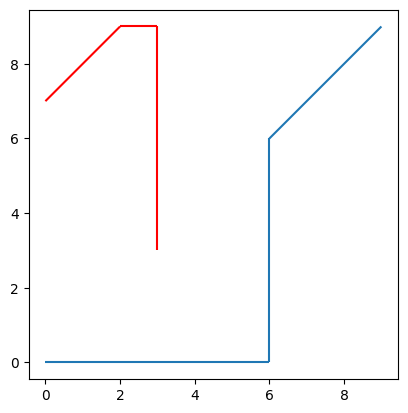

In [58]:
# 展示轨迹
ax = toy_traj.plot()
toy_traj2.plot(ax=ax, color='red')

In [59]:
# 计算距离，默认单位由坐标系单位决定，该坐标系单位为米
print(toy_traj.distance(toy_traj2))
# 计算hausdorff距离，默认单位由坐标系单位决定。
print(toy_traj.hausdorff_distance(toy_traj2))

3.0
6.082762530298219


In [60]:
# 计算距离,units自定义单位为厘米
print(toy_traj.distance(toy_traj2, units="cm"))
# 计算hausdorff距离,units自定义单位为英寸
print(toy_traj.hausdorff_distance(toy_traj2, units="ft"))

300.0
19.95656998129337


# 2 轨迹绘图实例之海鸥迁徙轨迹分析

基于海鸥迁徙数据来分析其移动轨迹。数据下载地址：[movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)。

**step1 加载数据**

In [61]:
df = read_file('data/gulls.gpkg')
# 展示数据
df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
0,1082620685,true,2009-05-27 14:00:00.000,24.58617,61.24783,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58617 61.24783)
1,1082620686,true,2009-05-27 20:00:00.000,24.58217,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58217 61.23267)
2,1082620687,true,2009-05-28 05:00:00.000,24.53133,61.18833,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.53133 61.18833)
3,1082620688,true,2009-05-28 08:00:00.000,24.58200,61.23283,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58200 61.23283)
4,1082620689,true,2009-05-28 14:00:00.000,24.58250,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58250 61.23267)


In [62]:
# 查看数据维度
df.shape

(89867, 11)

<Axes: >

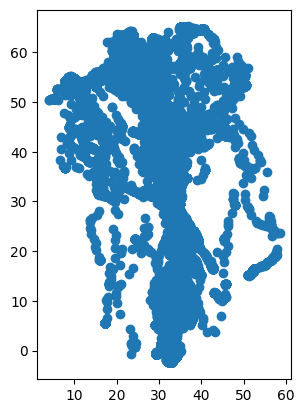

In [63]:
# 展示数据坐标点
df.plot()

In [64]:
# 海鸥唯一id
df['individual-local-identifier'].unique()

array(['91732A', '91733A', '91734A', '91735A', '91737A', '91738A',
       '91739A', '91740A', '91741A', '91742A', '91743A', '91744A',
       '91745A', '91746A', '91747A', '91748A', '91749A', '91750A',
       '91751A', '91752A', '91754A', '91755A', '91756A', '91758A',
       '91759A', '91761A', '91762A', '91763A', '91764A', '91765A',
       '91766A', '91767A', '91769A', '91771A', '91774A', '91775A',
       '91776A', '91777A', '91778A', '91779A', '91780A', '91781A',
       '91782A', '91783A', '91785A', '91786A', '91787A', '91788A',
       '91789A', '91794A', '91795A', '91797A', '91798A', '91799A',
       '91800A', '91802A', '91803A', '91807A', '91809A', '91810A',
       '91811A', '91812A', '91813A', '91814A', '91815A', '91816A',
       '91819A', '91821A', '91823A', '91824A', '91825A', '91826A',
       '91827A', '91828A', '91829A', '91830A', '91831A', '91832A',
       '91835A', '91836A', '91837A', '91838A', '91839A', '91843A',
       '91845A', '91846A', '91848A', '91849A', '91852A', '9185

In [65]:
# 海鸥数量
len(df['individual-local-identifier'].unique())

126

<Axes: xlabel='individual-local-identifier'>

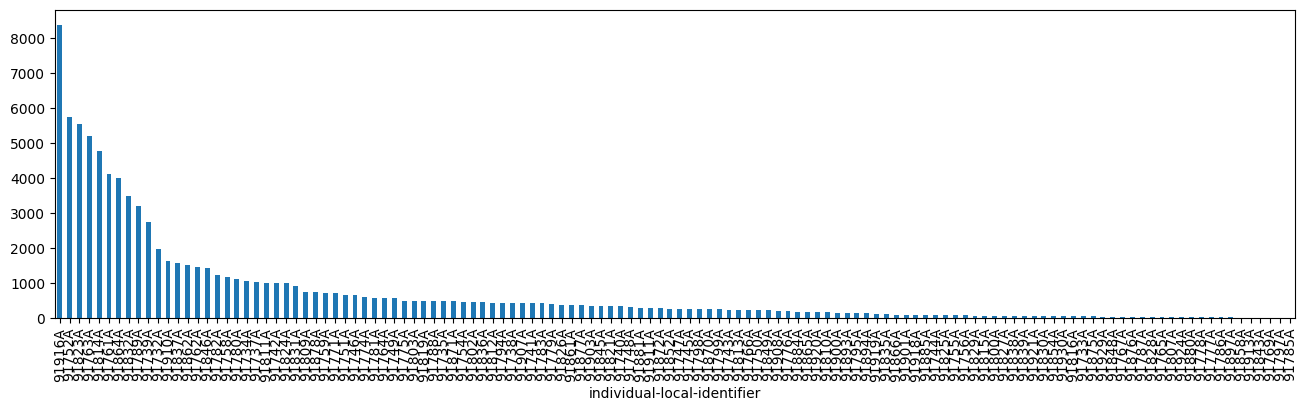

In [66]:
# 查看海鸥个体轨迹记录数，可以看到呈长尾分布
df['individual-local-identifier'].value_counts().plot(kind='bar', figsize=(16,4))

In [67]:
# 创建轨迹集合，以海鸥编号为轨迹编号
tc = mpd.TrajectoryCollection(df, traj_id_col='individual-local-identifier', t='timestamp', min_length=100, crs='EPSG:3857')    
tc

TrajectoryCollection with 125 trajectories

In [68]:
# 压缩轨迹
tc = mpd.MinTimeDeltaGeneralizer(tc).generalize(tolerance=timedelta(days=1))

**step2 个体分析**

In [69]:
# 挑选个体编号91916A的海鸥轨迹，该海鸥轨迹记录数最多
filtered = tc.filter('individual-local-identifier', '91916A')
my_traj = filtered.trajectories[0].copy()
my_traj

Trajectory 91916A (2009-08-15 15:00:00 to 2015-08-27 09:00:00) | Size: 2134 | Length: 77841407.0m
Bounds: (7.915, 20.70533, 39.51317, 61.54817)
LINESTRING (7.915 54.18533, 9.44183 54.87233, 9.4425 54.87283, 9.41167 54.8555, 9.39583 54.88, 9.396

<Axes: >

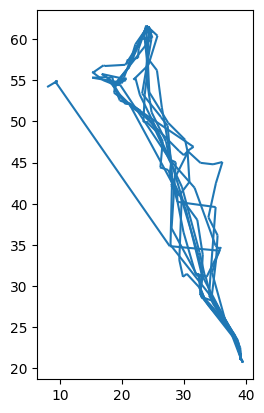

In [70]:
# 展示轨迹信息
# my_traj.hvplot(title='Movement', line_width=2) 
my_traj.plot()

由上图可以看到该海鸥一直呈现季节性来回移动。所以按照年份，将该海鸥的轨迹信息进行拆分。

In [71]:
trips_by_year = mpd.TemporalSplitter(filtered).split(mode='year')
trips_by_year.to_traj_gdf()

,traj_id,start_t,end_t,geometry,length,direction
0,91916A_2009-12-31 00:00:00,2009-08-15 15:00:00,2009-12-31 19:00:00,"LINESTRING (7.91500 54.18533, 9.44183 54.87233...",5.352375e+06,131.939002
1,91916A_2010-12-31 00:00:00,2010-01-01 19:00:00,2010-12-31 07:00:00,"LINESTRING (39.18417 21.17583, 39.18833 21.170...",1.232428e+07,281.047091
2,91916A_2011-12-31 00:00:00,2011-01-01 07:00:00,2011-12-31 04:00:00,"LINESTRING (39.17000 21.18017, 39.16883 21.156...",1.441793e+07,189.238229
3,91916A_2012-12-31 00:00:00,2012-01-01 04:00:00,2012-12-31 19:00:00,"LINESTRING (39.16933 21.16667, 39.17567 21.142...",1.324811e+07,62.132640
4,91916A_2013-12-31 00:00:00,2013-01-01 19:00:00,2013-12-31 13:00:00,"LINESTRING (39.18167 21.17333, 39.18100 21.173...",1.293261e+07,273.165851
5,91916A_2014-12-31 00:00:00,2014-01-01 13:00:00,2014-12-31 19:00:00,"LINESTRING (39.17083 21.15400, 39.17100 21.157...",1.300973e+07,33.742967
6,91916A_2015-12-31 00:00:00,2015-01-01 19:00:00,2015-08-27 09:00:00,"LINESTRING (39.18167 21.16967, 39.18233 21.169...",6.551740e+06,343.887905


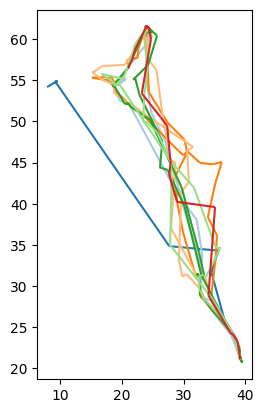

In [72]:
# 按照年份显示轨迹
from matplotlib.cm import tab20
ax = None
for index,tmp in enumerate(trips_by_year):
    if ax is None:
        ax = tmp.plot(color=tab20(index))
    else:
        ax= tmp.plot(ax=ax,color=tab20(index))

我们可以单独提取某一年的数据进行可视化，如下展示某一年速度：

<Axes: >

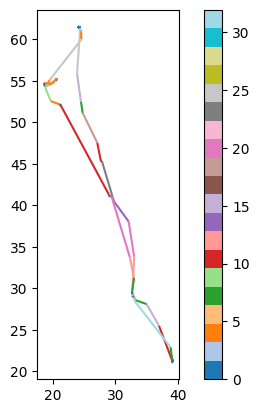

In [73]:
one_year = trips_by_year.get_trajectory('91916A_2010-12-31 00:00:00')
one_year.add_speed(overwrite=True,units=("km", "h"))
# 可视化当年的轨迹
one_year.plot(column='speed', cmap='tab20', legend=True)

当然也可以可是轨迹中某一天的结果，如下所示：

<Axes: >

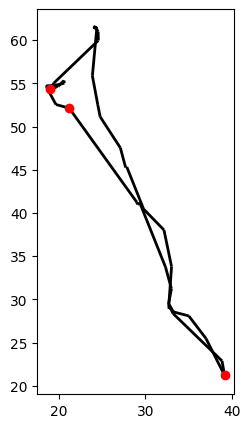

In [74]:

fig, ax = plt.subplots(figsize=(5, 5))
one_year.plot(ax=ax, linewidth=2.0, color='black')
GeoDataFrame([one_year.get_row_at(datetime(2010,9,1))]).plot(ax=ax, color='red',zorder=2)
GeoDataFrame([one_year.get_row_at(datetime(2010,10,1))]).plot(ax=ax, color='red',zorder=2)
GeoDataFrame([one_year.get_row_at(datetime(2010,11,1))]).plot(ax=ax, color='red',zorder=2)

此外也可以选择一个区域，比如栖息地。以确定某一轨迹到达该区域的次数及进出时间。

In [75]:
area_of_interest = Polygon([(30, 25), (50, 25), (50, 15), (30, 15), (30, 25)])
plotted_area_of_interest = GeoDataFrame(pd.DataFrame([{'geometry': area_of_interest, 'id': 1}]), crs='EPSG:3857')
# 输入的是单个轨迹得到的单个轨迹位于该区域的片段
arrivals = [traj for traj in my_traj.clip(area_of_interest)]
# 位于该区域的轨迹片段数
print("Found {} arrivals".format({len(arrivals)}))
# 提取每条轨迹到达该区域的时间
for traj in arrivals:
    name = traj.df['individual-local-identifier'].iloc[0]
    start_time = traj.get_start_time()
    end_time = traj.get_end_time()
    print("Individual {} arrived at {} left at {}".format(name, start_time, end_time))

Found {6} arrivals
Individual 91916A arrived at 2009-12-23 02:58:36.946571 left at 2010-04-17 14:31:42.170632
Individual 91916A arrived at 2010-10-30 20:55:36.697832 left at 2011-04-03 11:40:12.803103
Individual 91916A arrived at 2011-11-09 20:25:19.550486 left at 2012-04-04 09:12:15.852988
Individual 91916A arrived at 2012-10-14 11:25:28.063070 left at 2013-03-30 04:22:18.125679
Individual 91916A arrived at 2013-10-08 04:17:33.524488 left at 2014-03-29 18:26:54.311106
Individual 91916A arrived at 2014-10-28 19:05:32.941608 left at 2015-04-07 22:59:45.284499


**step3 群体分析**

step2中对单个轨迹Trajectory类进行分析，同样的函数也可以应用到轨迹集合TrajectoryCollection类中以对多条轨迹进行分析。

In [76]:
year_of_interest = 2010
# 输入的是多个轨迹得到的位于该区域的单个轨迹
trajs_in_aoi = tc.clip(area_of_interest)
# 提取2010到达该区域的轨迹
relevant = [ traj for traj in trajs_in_aoi if traj.get_start_time().year <= year_of_interest 
            and traj.get_end_time().year >= year_of_interest]
# 查看有多少只海鸥，也就是多少条单个轨迹到达该区域
print("Found {} arrivals".format(len(relevant)))

Found 16 arrivals


In [77]:
# 查看哪些海鸥到达该区域以及停留时间
for traj in relevant:
    print("Individual '{}' arrived at {} (duration: {})".format(
        traj.df['individual-local-identifier'].iloc[0], traj.get_start_time().date(), 
        traj.get_end_time()-traj.get_start_time()))

Individual '91732A' arrived at 2010-04-10 (duration: 5 days, 21:27:11.670985)
Individual '91737A' arrived at 2009-12-08 (duration: 140 days, 11:11:29.473206)
Individual '91761A' arrived at 2010-04-11 (duration: 12 days, 6:10:03.857850)
Individual '91761A' arrived at 2010-10-04 (duration: 6 days, 10:42:00.340093)
Individual '91762A' arrived at 2010-04-19 (duration: 42 days, 1:28:22.699066)
Individual '91771A' arrived at 2009-12-23 (duration: 66 days, 8:05:31.053782)
Individual '91789A' arrived at 2009-11-10 (duration: 550 days, 20:39:18.769409)
Individual '91824A' arrived at 2010-05-06 (duration: 12:53:53.409236)
Individual '91832A' arrived at 2010-04-21 (duration: 3 days, 5:48:46.276706)
Individual '91832A' arrived at 2010-09-23 (duration: 1 day, 1:40:25.175880)
Individual '91837A' arrived at 2010-05-04 (duration: 1 day, 18:38:46.170554)
Individual '91846A' arrived at 2010-05-15 (duration: 10 days, 2:50:28.505732)
Individual '91862A' arrived at 2010-01-06 (duration: 248 days, 6:10:16.9

对于'91761A'这只海鸥，可以看到进入该区域两次。我们可以展示这只海鸥在当年的飞行轨迹并添加背景地图以更好展示这只海鸥的行进情况。

<Axes: >

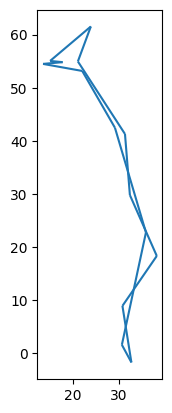

In [78]:
my_traj = tc.get_trajectory('91761A')
# 提取当年飞行结果
my_traj = my_traj.get_segment_between(datetime(year_of_interest,1,1), datetime(year_of_interest,12,31))
# 压缩轨迹,tolerance越大压缩比例越大
my_traj = mpd.DouglasPeuckerGeneralizer(my_traj).generalize(tolerance=2.0)
my_traj.plot()


通过如下代码绘制该海鸥的飞行轨迹，可以看到其在去途和归途都穿过了该地区，其中添加的背景地图具体使用方法见[GeoPandas叠加背景地图](https://www.cnblogs.com/luohenyueji/p/17485432.html#5-%E8%83%8C%E6%99%AF%E5%9C%B0%E5%9B%BE%E5%8F%A0%E5%8A%A0)。

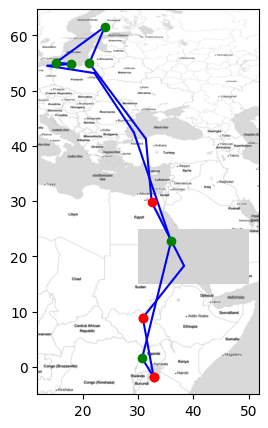

In [79]:
import contextily as cx
fig, ax = plt.subplots(figsize=(3, 5))
# 添加飞行轨迹
ax = my_traj.plot(ax=ax,color='blue', capstyle='round')
# 添加停留区域
ax = gpd.GeoSeries(area_of_interest).plot(ax=ax, color='lightgray')
# 绘制1月到11月的位置，12月该鸟飞回原地
for i in range(1,12):
    # 红点表示上半年，绿点表示下半年
    color = 'red' if i<6 else 'green'
    GeoDataFrame([my_traj.get_row_at(datetime(year_of_interest,i,1))]).plot(ax=ax, color=color,zorder=2)

# 添加背景地图,zoom越大越精细，这里使用自适应zoom。
cx.add_basemap(ax = ax , source=cx.providers.Stamen.TonerLite,crs=my_traj.df.crs, zoom='auto',attribution="")
# 保存图片
fig.savefig("res.jpg",dpi=300)


# 3 参考

+ [movingpandas](https://github.com/movingpandas/movingpandas)
+ [movingpandas-examples](https://github.com/movingpandas/movingpandas-examples)
+ [movingpandas-examples-data](https://github.com/movingpandas/movingpandas-examples/tree/main/data)
+ [shapely-objectdistance](https://shapely.readthedocs.io/en/stable/manual.html#object.distance)
+ [豪斯多夫距离](https://www.cnblogs.com/yhlx125/p/5478147.html)
+ [GeoPandas叠加背景地图](https://www.cnblogs.com/luohenyueji/p/17485432.html#5-%E8%83%8C%E6%99%AF%E5%9C%B0%E5%9B%BE%E5%8F%A0%E5%8A%A0)